# Train a reinforcement model that follows the line

First we import the necessary simulator libraries
- CarModel: a simulated car
- CanvasModel: a simulated training ground where the car can follow a line
- SimulatorControl: an environment where we can simulate actions like driving forward or turning left and right and read out new sensor values

In [1]:
import logging
import Car
import Canvas
import RobotCarSimulator

Model hyperparameters

In [2]:
GAMMA = 0.995             # discount factor
ALPHA = 1e-2              # learning rate  
TAU = 1e-2                # soft update
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
STEPS_SENSOR_HISTORY = 2
MEMORY_SIZE = 10_000     # size of memory buffer
MINIBATCH_SIZE = 64   # mini-batch size
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

In [3]:
car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=11)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False, stephistory=STEPS_SENSOR_HISTORY)

## Action space

- 0 - driveForward(100,150)
- 1 - turnLeft(100,50)
- 2 - turnRight(100,50)

In [4]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

num_actions = len(actions)

#to invoke action 0:
#actions[0]()

## Observation space

the observation space is only the sensor values of the 3 infrared sensors (two time steps ) ==>
- current sensor values
- previous sensor values

In [5]:
import numpy as np

def getReward():
    global sim
    return sim.getReward()

def getSensors():
    global sim
    return list(sim.getPreviousLineTrackingSensorValues()) + sim.getLineTrackingSensorValues()

def getDuration():
    global sim
    return sim.getDuration()

def isDone():
    global sim
    return sim.isTerminated()


# run one step and return next state (sensors), reward, done and time exceeded
def step(action):
    action()
    return (np.array(getSensors()), isDone(), getReward(), getDuration())
    
next_state, done, reward, duration = step(actions[0])     
    
state_size = 3 * (STEPS_SENSOR_HISTORY+1) # we have three sensors and n+1 time steps (n+1 * 3)

print(next_state, done, reward, duration) 

[ 30.         557.35703254 814.33883274  30.         557.35703254
 814.33883274  30.         146.91333487 900.        ] False 20.0 0.25


# Deep Q-learning (reinforcement learning)

as learned in the coursera course we will use two models, the Q and target Q' networks (Deep Q Network) DQN.

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple # for experience replay
import numpy as np
import random

In [7]:
# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])


optimizer = Adam(learning_rate=ALPHA)           


2022-08-23 17:10:26.398966: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 17:10:26.399259: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Experience replay 

The coursera course recommends to use experience replay to avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [8]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [9]:
# calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [10]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [11]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [12]:
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(num_actions))

In [13]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [14]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [15]:
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [16]:
import time
import pprint
import sys
start = time.time()

num_episodes = 2000
max_num_timesteps = 200

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
# learn with 9 different curves to generalize the model and not optimize for a single curve
seeds = (2,5,9,11,13,15,17,19,21)

duration = 0.0

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    seed = seeds[i%len(seeds)]
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False, stephistory=STEPS_SENSOR_HISTORY)
    state = np.array(getSensors())
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, done, reward, duration = step(actions[action])   
       
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            #print("\nUpdating model after ",t," steps")
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            print("\nBreaking episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            break
        if (t==(max_num_timesteps-1)):
            print("\nAborting episode ",i," with seed ", seed, " after ",t," steps with reward ",total_points)
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        with open('train_episode_{}_seed_{}.txt'.format(i,seed), 'w') as f:
            f.write("actions:\n")
            f.write(pprint.pformat(sim._actionLog))
            f.write("\n\npositions:\n")
            f.write(pprint.pformat(sim._carPositions))
            f.write("\n\norientations:\n")
            f.write(pprint.pformat(sim._carOrientations))

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 14000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('curve_tracking_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
q_network.save('curve_tracking_model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Breaking episode  0  with seed  2  after  99  steps with reward  -14330.0
Episode 1 | Total point average of the last 100 episodes: -14330.00
Breaking episode  1  with seed  5  after  120  steps with reward  -13820.0
Episode 2 | Total point average of the last 100 episodes: -14075.00
Breaking episode  2  with seed  9  after  51  steps with reward  -23180.0
Episode 3 | Total point average of the last 100 episodes: -17110.00
Breaking episode  3  with seed  11  after  148  steps with reward  -33100.0
Epis

Episode 52 | Total point average of the last 100 episodes: -25514.04
Breaking episode  52  with seed  19  after  64  steps with reward  -4830.0
Episode 53 | Total point average of the last 100 episodes: -25123.77
Breaking episode  53  with seed  21  after  116  steps with reward  -11760.0
Episode 54 | Total point average of the last 100 episodes: -24876.30
Aborting episode  54  with seed  2  after  199  steps with reward  -26700.0
Episode 55 | Total point average of the last 100 episodes: -24909.45
Breaking episode  55  with seed  5  after  178  steps with reward  -3900.0
Episode 56 | Total point average of the last 100 episodes: -24534.29
Aborting episode  56  with seed  9  after  199  steps with reward  -31280.0
Episode 57 | Total point average of the last 100 episodes: -24652.63
Breaking episode  57  with seed  11  after  67  steps with reward  -24900.0
Episode 58 | Total point average of the last 100 episodes: -24656.90
Breaking episode  58  with seed  13  after  143  steps with re

Episode 109 | Total point average of the last 100 episodes: -20563.30
Breaking episode  109  with seed  5  after  60  steps with reward  -24220.0
Episode 110 | Total point average of the last 100 episodes: -20665.30
Breaking episode  110  with seed  9  after  106  steps with reward  -27320.0
Episode 111 | Total point average of the last 100 episodes: -20611.30
Breaking episode  111  with seed  11  after  87  steps with reward  -26620.0
Episode 112 | Total point average of the last 100 episodes: -20599.50
Breaking episode  112  with seed  13  after  106  steps with reward  -11900.0
Episode 113 | Total point average of the last 100 episodes: -20261.50
Breaking episode  113  with seed  15  after  29  steps with reward  -3580.0
Episode 114 | Total point average of the last 100 episodes: -19902.00
Breaking episode  114  with seed  17  after  64  steps with reward  -9570.0
Episode 115 | Total point average of the last 100 episodes: -19593.50
Breaking episode  115  with seed  19  after  29  s

Episode 165 | Total point average of the last 100 episodes: -12147.70
Breaking episode  165  with seed  11  after  55  steps with reward  -7330.0
Episode 166 | Total point average of the last 100 episodes: -12019.50
Aborting episode  166  with seed  13  after  199  steps with reward  -10300.0
Episode 167 | Total point average of the last 100 episodes: -11858.70
Breaking episode  167  with seed  15  after  5  steps with reward  -14970.0
Episode 168 | Total point average of the last 100 episodes: -11886.60
Aborting episode  168  with seed  17  after  199  steps with reward  -990.0
Episode 169 | Total point average of the last 100 episodes: -12084.70
Aborting episode  169  with seed  19  after  199  steps with reward  -6520.0
Episode 170 | Total point average of the last 100 episodes: -11954.00
Aborting episode  170  with seed  21  after  199  steps with reward  -17820.0
Episode 171 | Total point average of the last 100 episodes: -12126.80
Aborting episode  171  with seed  2  after  199  

Episode 222 | Total point average of the last 100 episodes: -3914.30
Aborting episode  222  with seed  17  after  199  steps with reward  3420.0
Episode 223 | Total point average of the last 100 episodes: -3730.40
Breaking episode  223  with seed  19  after  78  steps with reward  940.0
Episode 224 | Total point average of the last 100 episodes: -3747.70
Breaking episode  224  with seed  21  after  70  steps with reward  -10240.0
Episode 225 | Total point average of the last 100 episodes: -3649.10
Aborting episode  225  with seed  2  after  199  steps with reward  -3800.0
Episode 226 | Total point average of the last 100 episodes: -3470.00
Aborting episode  226  with seed  5  after  199  steps with reward  -7160.0
Episode 227 | Total point average of the last 100 episodes: -3438.80
Breaking episode  227  with seed  9  after  112  steps with reward  -7550.0
Episode 228 | Total point average of the last 100 episodes: -3509.00
Aborting episode  228  with seed  11  after  199  steps with r

Episode 279 | Total point average of the last 100 episodes: -2309.80
Aborting episode  279  with seed  2  after  199  steps with reward  1320.0
Episode 280 | Total point average of the last 100 episodes: -2059.20
Aborting episode  280  with seed  5  after  199  steps with reward  -540.0
Episode 281 | Total point average of the last 100 episodes: -2260.30
Aborting episode  281  with seed  9  after  199  steps with reward  4640.0
Episode 282 | Total point average of the last 100 episodes: -2195.50
Aborting episode  282  with seed  11  after  199  steps with reward  2890.0
Episode 283 | Total point average of the last 100 episodes: -2149.50
Breaking episode  283  with seed  13  after  48  steps with reward  -2830.0
Episode 284 | Total point average of the last 100 episodes: -2023.20
Breaking episode  284  with seed  15  after  5  steps with reward  -14970.0
Episode 285 | Total point average of the last 100 episodes: -2211.70
Breaking episode  285  with seed  17  after  176  steps with rew

Episode 336 | Total point average of the last 100 episodes: -2323.60
Aborting episode  336  with seed  11  after  199  steps with reward  3430.0
Episode 337 | Total point average of the last 100 episodes: -2296.50
Breaking episode  337  with seed  13  after  42  steps with reward  -2480.0
Episode 338 | Total point average of the last 100 episodes: -2267.00
Breaking episode  338  with seed  15  after  3  steps with reward  -14970.0
Episode 339 | Total point average of the last 100 episodes: -2603.90
Breaking episode  339  with seed  17  after  134  steps with reward  -14020.0
Episode 340 | Total point average of the last 100 episodes: -2594.40
Aborting episode  340  with seed  19  after  199  steps with reward  -39040.0
Episode 341 | Total point average of the last 100 episodes: -2946.70
Breaking episode  341  with seed  21  after  177  steps with reward  19240.0
Episode 342 | Total point average of the last 100 episodes: -2604.90
Aborting episode  342  with seed  2  after  199  steps w

Episode 393 | Total point average of the last 100 episodes: 1321.90
Breaking episode  393  with seed  17  after  186  steps with reward  -2870.0
Episode 394 | Total point average of the last 100 episodes: 1287.90
Breaking episode  394  with seed  19  after  110  steps with reward  19100.0
Episode 395 | Total point average of the last 100 episodes: 1457.30
Breaking episode  395  with seed  21  after  196  steps with reward  17930.0
Episode 396 | Total point average of the last 100 episodes: 1627.10
Breaking episode  396  with seed  2  after  87  steps with reward  18530.0
Episode 397 | Total point average of the last 100 episodes: 1860.80
Aborting episode  397  with seed  5  after  199  steps with reward  4100.0
Episode 398 | Total point average of the last 100 episodes: 1897.00
Breaking episode  398  with seed  9  after  58  steps with reward  280.0
Episode 399 | Total point average of the last 100 episodes: 1901.80
Breaking episode  399  with seed  11  after  198  steps with reward  1

Episode 450 | Total point average of the last 100 episodes: 6692.90
Aborting episode  450  with seed  2  after  199  steps with reward  990.0
Episode 451 | Total point average of the last 100 episodes: 6521.40
Breaking episode  451  with seed  5  after  32  steps with reward  -18300.0
Episode 452 | Total point average of the last 100 episodes: 6162.20
Breaking episode  452  with seed  9  after  74  steps with reward  280.0
Episode 453 | Total point average of the last 100 episodes: 6133.00
Aborting episode  453  with seed  11  after  199  steps with reward  1810.0
Episode 454 | Total point average of the last 100 episodes: 6142.90
Breaking episode  454  with seed  13  after  108  steps with reward  -6320.0
Episode 455 | Total point average of the last 100 episodes: 6052.60
Aborting episode  455  with seed  15  after  199  steps with reward  2320.0
Episode 456 | Total point average of the last 100 episodes: 5882.90
Aborting episode  456  with seed  17  after  199  steps with reward  940

Episode 507 | Total point average of the last 100 episodes: 6091.20
Breaking episode  507  with seed  11  after  126  steps with reward  17970.0
Episode 508 | Total point average of the last 100 episodes: 6350.90
Breaking episode  508  with seed  13  after  55  steps with reward  16510.0
Episode 509 | Total point average of the last 100 episodes: 6500.00
Breaking episode  509  with seed  15  after  110  steps with reward  16980.0
Episode 510 | Total point average of the last 100 episodes: 6738.20
Breaking episode  510  with seed  17  after  142  steps with reward  2130.0
Episode 511 | Total point average of the last 100 episodes: 6573.60
Aborting episode  511  with seed  19  after  199  steps with reward  1930.0
Episode 512 | Total point average of the last 100 episodes: 6563.10
Breaking episode  512  with seed  21  after  65  steps with reward  16740.0
Episode 513 | Total point average of the last 100 episodes: 6711.50
Breaking episode  513  with seed  2  after  68  steps with reward 

Episode 564 | Total point average of the last 100 episodes: 10006.80
Breaking episode  564  with seed  17  after  156  steps with reward  2780.0
Episode 565 | Total point average of the last 100 episodes: 9856.70
Aborting episode  565  with seed  19  after  199  steps with reward  1790.0
Episode 566 | Total point average of the last 100 episodes: 9849.70
Breaking episode  566  with seed  21  after  184  steps with reward  17070.0
Episode 567 | Total point average of the last 100 episodes: 10002.40
Breaking episode  567  with seed  2  after  184  steps with reward  16210.0
Episode 568 | Total point average of the last 100 episodes: 10310.40
Aborting episode  568  with seed  5  after  199  steps with reward  2260.0
Episode 569 | Total point average of the last 100 episodes: 10311.90
Breaking episode  569  with seed  9  after  23  steps with reward  -14810.0
Episode 570 | Total point average of the last 100 episodes: 10149.50
Breaking episode  570  with seed  11  after  35  steps with rew

Episode 621 | Total point average of the last 100 episodes: 6816.80
Aborting episode  621  with seed  2  after  199  steps with reward  -2300.0
Episode 622 | Total point average of the last 100 episodes: 6617.40
Aborting episode  622  with seed  5  after  199  steps with reward  2370.0
Episode 623 | Total point average of the last 100 episodes: 6476.90
Breaking episode  623  with seed  9  after  75  steps with reward  -14620.0
Episode 624 | Total point average of the last 100 episodes: 6513.70
Aborting episode  624  with seed  11  after  199  steps with reward  690.0
Episode 625 | Total point average of the last 100 episodes: 6512.60
Breaking episode  625  with seed  13  after  147  steps with reward  17270.0
Episode 626 | Total point average of the last 100 episodes: 6659.20
Aborting episode  626  with seed  15  after  199  steps with reward  1390.0
Episode 627 | Total point average of the last 100 episodes: 6504.50
Aborting episode  627  with seed  17  after  199  steps with reward  

Episode 678 | Total point average of the last 100 episodes: 5529.30
Aborting episode  678  with seed  11  after  199  steps with reward  1890.0
Episode 679 | Total point average of the last 100 episodes: 5696.30
Aborting episode  679  with seed  13  after  199  steps with reward  2850.0
Episode 680 | Total point average of the last 100 episodes: 5721.00
Breaking episode  680  with seed  15  after  177  steps with reward  16820.0
Episode 681 | Total point average of the last 100 episodes: 5878.80
Breaking episode  681  with seed  17  after  156  steps with reward  2950.0
Episode 682 | Total point average of the last 100 episodes: 6058.00
Breaking episode  682  with seed  19  after  16  steps with reward  -14840.0
Episode 683 | Total point average of the last 100 episodes: 5890.00
Aborting episode  683  with seed  21  after  199  steps with reward  1440.0
Episode 684 | Total point average of the last 100 episodes: 5731.70
Aborting episode  684  with seed  2  after  199  steps with reward

Episode 735 | Total point average of the last 100 episodes: 4651.70
Aborting episode  735  with seed  17  after  199  steps with reward  1510.0
Episode 736 | Total point average of the last 100 episodes: 4653.80
Aborting episode  736  with seed  19  after  199  steps with reward  -9840.0
Episode 737 | Total point average of the last 100 episodes: 4542.40
Breaking episode  737  with seed  21  after  29  steps with reward  -14620.0
Episode 738 | Total point average of the last 100 episodes: 4221.80
Breaking episode  738  with seed  2  after  15  steps with reward  -14850.0
Episode 739 | Total point average of the last 100 episodes: 3901.40
Aborting episode  739  with seed  5  after  199  steps with reward  -16510.0
Episode 740 | Total point average of the last 100 episodes: 3723.80
Breaking episode  740  with seed  9  after  53  steps with reward  -14700.0
Episode 741 | Total point average of the last 100 episodes: 3619.30
Aborting episode  741  with seed  11  after  199  steps with rewa

Episode 792 | Total point average of the last 100 episodes: 3347.30
Breaking episode  792  with seed  2  after  137  steps with reward  16770.0
Episode 793 | Total point average of the last 100 episodes: 3491.60
Breaking episode  793  with seed  5  after  145  steps with reward  16920.0
Episode 794 | Total point average of the last 100 episodes: 3500.00
Breaking episode  794  with seed  9  after  37  steps with reward  -14620.0
Episode 795 | Total point average of the last 100 episodes: 3448.30
Aborting episode  795  with seed  11  after  199  steps with reward  2600.0
Episode 796 | Total point average of the last 100 episodes: 3468.70
Breaking episode  796  with seed  13  after  76  steps with reward  16920.0
Episode 797 | Total point average of the last 100 episodes: 3626.00
Breaking episode  797  with seed  15  after  22  steps with reward  -14810.0
Episode 798 | Total point average of the last 100 episodes: 3311.70
Breaking episode  798  with seed  17  after  134  steps with reward

Episode 849 | Total point average of the last 100 episodes: 7630.20
Aborting episode  849  with seed  11  after  199  steps with reward  2300.0
Episode 850 | Total point average of the last 100 episodes: 7799.40
Breaking episode  850  with seed  13  after  193  steps with reward  17270.0
Episode 851 | Total point average of the last 100 episodes: 7959.30
Breaking episode  851  with seed  15  after  150  steps with reward  16250.0
Episode 852 | Total point average of the last 100 episodes: 8109.10
Breaking episode  852  with seed  17  after  147  steps with reward  1930.0
Episode 853 | Total point average of the last 100 episodes: 7960.50
Breaking episode  853  with seed  19  after  150  steps with reward  17110.0
Episode 854 | Total point average of the last 100 episodes: 7994.40
Breaking episode  854  with seed  21  after  101  steps with reward  16990.0
Episode 855 | Total point average of the last 100 episodes: 7999.00
Breaking episode  855  with seed  2  after  68  steps with rewar

Episode 906 | Total point average of the last 100 episodes: 7575.70
Aborting episode  906  with seed  17  after  199  steps with reward  1540.0
Episode 907 | Total point average of the last 100 episodes: 7422.60
Breaking episode  907  with seed  19  after  192  steps with reward  17130.0
Episode 908 | Total point average of the last 100 episodes: 7576.20
Breaking episode  908  with seed  21  after  104  steps with reward  16990.0
Episode 909 | Total point average of the last 100 episodes: 7571.90
Breaking episode  909  with seed  2  after  68  steps with reward  16180.0
Episode 910 | Total point average of the last 100 episodes: 7564.10
Breaking episode  910  with seed  5  after  197  steps with reward  17130.0
Episode 911 | Total point average of the last 100 episodes: 7566.50
Breaking episode  911  with seed  9  after  185  steps with reward  17760.0
Episode 912 | Total point average of the last 100 episodes: 7572.90
Aborting episode  912  with seed  11  after  199  steps with reward

Episode 963 | Total point average of the last 100 episodes: 9122.40
Breaking episode  963  with seed  2  after  147  steps with reward  16680.0
Episode 964 | Total point average of the last 100 episodes: 9284.40
Aborting episode  964  with seed  5  after  199  steps with reward  2100.0
Episode 965 | Total point average of the last 100 episodes: 9134.20
Breaking episode  965  with seed  9  after  157  steps with reward  17170.0
Episode 966 | Total point average of the last 100 episodes: 9289.00
Breaking episode  966  with seed  11  after  140  steps with reward  17140.0
Episode 967 | Total point average of the last 100 episodes: 9606.60
Breaking episode  967  with seed  13  after  49  steps with reward  16710.0
Episode 968 | Total point average of the last 100 episodes: 9757.10
Breaking episode  968  with seed  15  after  118  steps with reward  16690.0
Episode 969 | Total point average of the last 100 episodes: 9754.00
Breaking episode  969  with seed  17  after  140  steps with reward

Episode 1019 | Total point average of the last 100 episodes: 11492.10
Breaking episode  1019  with seed  9  after  62  steps with reward  650.0
Episode 1020 | Total point average of the last 100 episodes: 11475.60
Breaking episode  1020  with seed  11  after  100  steps with reward  16820.0
Episode 1021 | Total point average of the last 100 episodes: 11789.90
Breaking episode  1021  with seed  13  after  92  steps with reward  16260.0
Episode 1022 | Total point average of the last 100 episodes: 11930.10
Breaking episode  1022  with seed  15  after  104  steps with reward  16740.0
Episode 1023 | Total point average of the last 100 episodes: 11928.40
Aborting episode  1023  with seed  17  after  199  steps with reward  2410.0
Episode 1024 | Total point average of the last 100 episodes: 11786.10
Breaking episode  1024  with seed  19  after  188  steps with reward  17640.0
Episode 1025 | Total point average of the last 100 episodes: 11947.50
Breaking episode  1025  with seed  21  after  12

Episode 1075 | Total point average of the last 100 episodes: 9850.40
Breaking episode  1075  with seed  13  after  69  steps with reward  16310.0
Episode 1076 | Total point average of the last 100 episodes: 9841.80
Breaking episode  1076  with seed  15  after  76  steps with reward  16290.0
Episode 1077 | Total point average of the last 100 episodes: 9831.80
Breaking episode  1077  with seed  17  after  142  steps with reward  1650.0
Episode 1078 | Total point average of the last 100 episodes: 9684.30
Aborting episode  1078  with seed  19  after  199  steps with reward  1520.0
Episode 1079 | Total point average of the last 100 episodes: 9680.70
Breaking episode  1079  with seed  21  after  120  steps with reward  16650.0
Episode 1080 | Total point average of the last 100 episodes: 9676.80
Breaking episode  1080  with seed  2  after  70  steps with reward  16190.0
Episode 1081 | Total point average of the last 100 episodes: 9666.90
Breaking episode  1081  with seed  5  after  157  steps

Episode 1131 | Total point average of the last 100 episodes: 8610.30
Aborting episode  1131  with seed  17  after  199  steps with reward  1680.0
Episode 1132 | Total point average of the last 100 episodes: 8460.00
Breaking episode  1132  with seed  19  after  142  steps with reward  17060.0
Episode 1133 | Total point average of the last 100 episodes: 8612.50
Breaking episode  1133  with seed  21  after  84  steps with reward  17940.0
Episode 1134 | Total point average of the last 100 episodes: 8622.10
Breaking episode  1134  with seed  2  after  140  steps with reward  16160.0
Episode 1135 | Total point average of the last 100 episodes: 8616.50
Breaking episode  1135  with seed  5  after  141  steps with reward  17280.0
Episode 1136 | Total point average of the last 100 episodes: 8624.50
Breaking episode  1136  with seed  9  after  37  steps with reward  -14630.0
Episode 1137 | Total point average of the last 100 episodes: 8455.50
Aborting episode  1137  with seed  11  after  199  ste

Episode 1187 | Total point average of the last 100 episodes: 9773.50
Breaking episode  1187  with seed  21  after  116  steps with reward  16760.0
Episode 1188 | Total point average of the last 100 episodes: 9774.70
Breaking episode  1188  with seed  2  after  69  steps with reward  16980.0
Episode 1189 | Total point average of the last 100 episodes: 9773.00
Breaking episode  1189  with seed  5  after  131  steps with reward  17950.0
Episode 1190 | Total point average of the last 100 episodes: 9789.50
Breaking episode  1190  with seed  9  after  37  steps with reward  -14620.0
Episode 1191 | Total point average of the last 100 episodes: 9625.30
Breaking episode  1191  with seed  11  after  140  steps with reward  17380.0
Episode 1192 | Total point average of the last 100 episodes: 9796.60
Breaking episode  1192  with seed  13  after  73  steps with reward  16530.0
Episode 1193 | Total point average of the last 100 episodes: 9788.90
Breaking episode  1193  with seed  15  after  90  step

Episode 1243 | Total point average of the last 100 episodes: 10204.40
Breaking episode  1243  with seed  5  after  173  steps with reward  17730.0
Episode 1244 | Total point average of the last 100 episodes: 10212.00
Breaking episode  1244  with seed  9  after  136  steps with reward  910.0
Episode 1245 | Total point average of the last 100 episodes: 10049.10
Breaking episode  1245  with seed  11  after  101  steps with reward  17540.0
Episode 1246 | Total point average of the last 100 episodes: 10370.80
Breaking episode  1246  with seed  13  after  115  steps with reward  16460.0
Episode 1247 | Total point average of the last 100 episodes: 10365.50
Breaking episode  1247  with seed  15  after  135  steps with reward  17360.0
Episode 1248 | Total point average of the last 100 episodes: 10372.00
Breaking episode  1248  with seed  17  after  162  steps with reward  2880.0
Episode 1249 | Total point average of the last 100 episodes: 10238.00
Aborting episode  1249  with seed  19  after  1

Episode 1299 | Total point average of the last 100 episodes: 11431.20
Breaking episode  1299  with seed  11  after  145  steps with reward  17030.0
Episode 1300 | Total point average of the last 100 episodes: 11590.50

Breaking episode  1300  with seed  13  after  59  steps with reward  16860.0
Episode 1301 | Total point average of the last 100 episodes: 11729.60
Breaking episode  1301  with seed  15  after  114  steps with reward  16670.0
Episode 1302 | Total point average of the last 100 episodes: 11726.90
Breaking episode  1302  with seed  17  after  149  steps with reward  1410.0
Episode 1303 | Total point average of the last 100 episodes: 11726.60
Breaking episode  1303  with seed  19  after  137  steps with reward  16880.0
Episode 1304 | Total point average of the last 100 episodes: 11885.00
Breaking episode  1304  with seed  21  after  106  steps with reward  16890.0
Episode 1305 | Total point average of the last 100 episodes: 11887.20
Breaking episode  1305  with seed  2  after

Episode 1356 | Total point average of the last 100 episodes: 11331.30
Breaking episode  1356  with seed  17  after  153  steps with reward  1500.0
Episode 1357 | Total point average of the last 100 episodes: 11172.70
Aborting episode  1357  with seed  19  after  199  steps with reward  220.0
Episode 1358 | Total point average of the last 100 episodes: 11157.70
Breaking episode  1358  with seed  21  after  90  steps with reward  16610.0
Episode 1359 | Total point average of the last 100 episodes: 11153.70
Breaking episode  1359  with seed  2  after  93  steps with reward  16450.0
Episode 1360 | Total point average of the last 100 episodes: 11143.50
Breaking episode  1360  with seed  5  after  105  steps with reward  16830.0
Episode 1361 | Total point average of the last 100 episodes: 11144.00
Breaking episode  1361  with seed  9  after  120  steps with reward  660.0
Episode 1362 | Total point average of the last 100 episodes: 10973.50
Breaking episode  1362  with seed  11  after  158  s

Episode 1412 | Total point average of the last 100 episodes: 11192.50
Breaking episode  1412  with seed  21  after  100  steps with reward  17540.0
Episode 1413 | Total point average of the last 100 episodes: 11196.10
Breaking episode  1413  with seed  2  after  68  steps with reward  17550.0
Episode 1414 | Total point average of the last 100 episodes: 11194.40
Breaking episode  1414  with seed  5  after  131  steps with reward  18260.0
Episode 1415 | Total point average of the last 100 episodes: 11212.60
Breaking episode  1415  with seed  9  after  66  steps with reward  -14510.0
Episode 1416 | Total point average of the last 100 episodes: 10893.20
Breaking episode  1416  with seed  11  after  132  steps with reward  19180.0
Episode 1417 | Total point average of the last 100 episodes: 11231.30
Breaking episode  1417  with seed  13  after  48  steps with reward  18680.0
Episode 1418 | Total point average of the last 100 episodes: 11407.50
Breaking episode  1418  with seed  15  after  7

Episode 1468 | Total point average of the last 100 episodes: 12882.00
Breaking episode  1468  with seed  5  after  129  steps with reward  18320.0
Episode 1469 | Total point average of the last 100 episodes: 12903.30
Breaking episode  1469  with seed  9  after  78  steps with reward  900.0
Episode 1470 | Total point average of the last 100 episodes: 12734.40
Breaking episode  1470  with seed  11  after  127  steps with reward  17730.0
Episode 1471 | Total point average of the last 100 episodes: 12906.20
Breaking episode  1471  with seed  13  after  44  steps with reward  18040.0
Episode 1472 | Total point average of the last 100 episodes: 12906.30
Breaking episode  1472  with seed  15  after  91  steps with reward  17430.0
Episode 1473 | Total point average of the last 100 episodes: 12900.80
Breaking episode  1473  with seed  17  after  149  steps with reward  17560.0
Episode 1474 | Total point average of the last 100 episodes: 12910.80
Breaking episode  1474  with seed  19  after  28 

Episode 1524 | Total point average of the last 100 episodes: 12599.20
Breaking episode  1524  with seed  11  after  143  steps with reward  18540.0
Episode 1525 | Total point average of the last 100 episodes: 12930.80
Breaking episode  1525  with seed  13  after  77  steps with reward  16340.0
Episode 1526 | Total point average of the last 100 episodes: 12910.40
Breaking episode  1526  with seed  15  after  80  steps with reward  18520.0
Episode 1527 | Total point average of the last 100 episodes: 12925.60
Aborting episode  1527  with seed  17  after  199  steps with reward  1840.0
Episode 1528 | Total point average of the last 100 episodes: 12763.70
Breaking episode  1528  with seed  19  after  150  steps with reward  17370.0
Episode 1529 | Total point average of the last 100 episodes: 12920.20
Breaking episode  1529  with seed  21  after  122  steps with reward  18000.0
Episode 1530 | Total point average of the last 100 episodes: 12918.00
Breaking episode  1530  with seed  2  after  

Episode 1580 | Total point average of the last 100 episodes: 13800.80
Breaking episode  1580  with seed  15  after  113  steps with reward  17590.0
Episode 1581 | Total point average of the last 100 episodes: 13798.90
Aborting episode  1581  with seed  17  after  199  steps with reward  2840.0
Episode 1582 | Total point average of the last 100 episodes: 13652.80
Aborting episode  1582  with seed  19  after  199  steps with reward  580.0
Episode 1583 | Total point average of the last 100 episodes: 13642.90
Breaking episode  1583  with seed  21  after  74  steps with reward  18900.0
Episode 1584 | Total point average of the last 100 episodes: 13653.60
Breaking episode  1584  with seed  2  after  95  steps with reward  18550.0
Episode 1585 | Total point average of the last 100 episodes: 13663.00
Aborting episode  1585  with seed  5  after  199  steps with reward  2930.0
Episode 1586 | Total point average of the last 100 episodes: 13505.30
Aborting episode  1586  with seed  9  after  199  

Episode 1636 | Total point average of the last 100 episodes: 12833.40
Breaking episode  1636  with seed  19  after  94  steps with reward  18410.0
Episode 1637 | Total point average of the last 100 episodes: 12842.50
Breaking episode  1637  with seed  21  after  92  steps with reward  18720.0
Episode 1638 | Total point average of the last 100 episodes: 12997.40
Breaking episode  1638  with seed  2  after  139  steps with reward  18160.0
Episode 1639 | Total point average of the last 100 episodes: 13008.60
Breaking episode  1639  with seed  5  after  101  steps with reward  18770.0
Episode 1640 | Total point average of the last 100 episodes: 13034.20
Breaking episode  1640  with seed  9  after  189  steps with reward  17710.0
Episode 1641 | Total point average of the last 100 episodes: 13029.70
Breaking episode  1641  with seed  11  after  137  steps with reward  18470.0
Episode 1642 | Total point average of the last 100 episodes: 13026.90
Breaking episode  1642  with seed  13  after  4

Episode 1692 | Total point average of the last 100 episodes: 11628.30
Breaking episode  1692  with seed  2  after  68  steps with reward  16960.0
Episode 1693 | Total point average of the last 100 episodes: 11615.00
Breaking episode  1693  with seed  5  after  146  steps with reward  18830.0
Episode 1694 | Total point average of the last 100 episodes: 11780.80
Breaking episode  1694  with seed  9  after  156  steps with reward  990.0
Episode 1695 | Total point average of the last 100 episodes: 11752.20
Breaking episode  1695  with seed  11  after  169  steps with reward  18020.0
Episode 1696 | Total point average of the last 100 episodes: 11745.20
Breaking episode  1696  with seed  13  after  47  steps with reward  17380.0
Episode 1697 | Total point average of the last 100 episodes: 11890.50
Breaking episode  1697  with seed  15  after  85  steps with reward  19710.0
Episode 1698 | Total point average of the last 100 episodes: 11908.10
Breaking episode  1698  with seed  17  after  117 

Episode 1748 | Total point average of the last 100 episodes: 12262.60
Breaking episode  1748  with seed  9  after  170  steps with reward  19720.0
Episode 1749 | Total point average of the last 100 episodes: 12279.70
Breaking episode  1749  with seed  11  after  122  steps with reward  17900.0
Episode 1750 | Total point average of the last 100 episodes: 12429.80
Breaking episode  1750  with seed  13  after  77  steps with reward  17330.0
Episode 1751 | Total point average of the last 100 episodes: 12428.40
Breaking episode  1751  with seed  15  after  114  steps with reward  17420.0
Episode 1752 | Total point average of the last 100 episodes: 12421.90
Breaking episode  1752  with seed  17  after  134  steps with reward  1740.0
Episode 1753 | Total point average of the last 100 episodes: 12251.90
Aborting episode  1753  with seed  19  after  199  steps with reward  2870.0
Episode 1754 | Total point average of the last 100 episodes: 12254.80
Breaking episode  1754  with seed  21  after  

Episode 1804 | Total point average of the last 100 episodes: 13083.60
Breaking episode  1804  with seed  13  after  146  steps with reward  17660.0
Episode 1805 | Total point average of the last 100 episodes: 13249.00
Breaking episode  1805  with seed  15  after  176  steps with reward  18030.0
Episode 1806 | Total point average of the last 100 episodes: 13253.20
Aborting episode  1806  with seed  17  after  199  steps with reward  1450.0
Episode 1807 | Total point average of the last 100 episodes: 13074.00
Aborting episode  1807  with seed  19  after  199  steps with reward  1610.0
Episode 1808 | Total point average of the last 100 episodes: 13063.40
Breaking episode  1808  with seed  21  after  143  steps with reward  17630.0
Episode 1809 | Total point average of the last 100 episodes: 13052.90
Aborting episode  1809  with seed  2  after  199  steps with reward  2540.0
Episode 1810 | Total point average of the last 100 episodes: 12895.40
Aborting episode  1810  with seed  5  after  1

Episode 1860 | Total point average of the last 100 episodes: 7848.40
Breaking episode  1860  with seed  17  after  177  steps with reward  1730.0
Episode 1861 | Total point average of the last 100 episodes: 7679.20
Aborting episode  1861  with seed  19  after  199  steps with reward  660.0
Episode 1862 | Total point average of the last 100 episodes: 7659.40
Aborting episode  1862  with seed  21  after  199  steps with reward  1750.0
Episode 1863 | Total point average of the last 100 episodes: 7646.30
Aborting episode  1863  with seed  2  after  199  steps with reward  -11270.0
Episode 1864 | Total point average of the last 100 episodes: 7360.00
Aborting episode  1864  with seed  5  after  199  steps with reward  1970.0
Episode 1865 | Total point average of the last 100 episodes: 7196.70
Breaking episode  1865  with seed  9  after  72  steps with reward  -14510.0
Episode 1866 | Total point average of the last 100 episodes: 6857.50
Aborting episode  1866  with seed  11  after  199  steps

Episode 1916 | Total point average of the last 100 episodes: 3330.30
Breaking episode  1916  with seed  21  after  95  steps with reward  17150.0
Episode 1917 | Total point average of the last 100 episodes: 3478.00
Breaking episode  1917  with seed  2  after  97  steps with reward  16740.0
Episode 1918 | Total point average of the last 100 episodes: 3465.00
Aborting episode  1918  with seed  5  after  199  steps with reward  2550.0
Episode 1919 | Total point average of the last 100 episodes: 3467.70
Breaking episode  1919  with seed  9  after  39  steps with reward  -14630.0
Episode 1920 | Total point average of the last 100 episodes: 3296.20
Aborting episode  1920  with seed  11  after  199  steps with reward  3460.0
Episode 1921 | Total point average of the last 100 episodes: 3322.00
Breaking episode  1921  with seed  13  after  69  steps with reward  16800.0
Episode 1922 | Total point average of the last 100 episodes: 3480.20
Breaking episode  1922  with seed  15  after  122  steps 

Episode 1972 | Total point average of the last 100 episodes: 7599.80
Breaking episode  1972  with seed  5  after  127  steps with reward  18320.0
Episode 1973 | Total point average of the last 100 episodes: 7763.50
Breaking episode  1973  with seed  9  after  63  steps with reward  -14620.0
Episode 1974 | Total point average of the last 100 episodes: 7598.10
Breaking episode  1974  with seed  11  after  100  steps with reward  17060.0
Episode 1975 | Total point average of the last 100 episodes: 7915.60
Breaking episode  1975  with seed  13  after  48  steps with reward  18360.0
Episode 1976 | Total point average of the last 100 episodes: 8085.10
Breaking episode  1976  with seed  15  after  124  steps with reward  17390.0
Episode 1977 | Total point average of the last 100 episodes: 8247.40
Aborting episode  1977  with seed  17  after  199  steps with reward  2000.0
Episode 1978 | Total point average of the last 100 episodes: 8100.10
Breaking episode  1978  with seed  19  after  170  st

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()
    

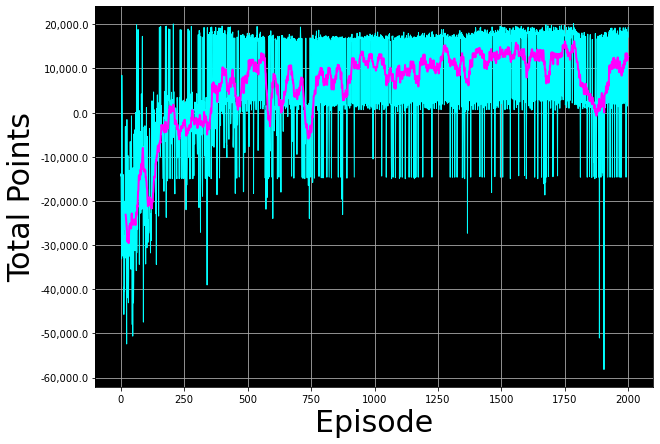

In [18]:
# Plot the point history
plot_history(total_point_history)

# Apply learned model and revisit results

In [19]:
import pprint
import sys
import logging
import Car
import Canvas
import RobotCarSimulator
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np

model = tf.keras.models.load_model('curve_tracking_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,995
Trainable params: 4,995
Non-trainable params: 0
_________________________________________________________________


In [20]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

# training curves used seeds (2,5,9,11,13,15,17,19,21)
# we use 7, and 23 in addition to see how the model performs on unknown curves
for seed in (2,5,7,9,11,13,15,17,19,21,23):
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=True, stephistory=STEPS_SENSOR_HISTORY)

    while not sim.isTerminated() and sim.getDuration() < 20.0:
        state_qn = np.expand_dims(np.array(list(sim.getPreviousLineTrackingSensorValues()) + sim.getLineTrackingSensorValues()), axis=0)
        q_values = model(state_qn)
        action = np.argmax(q_values.numpy()[0])
        actions[action]()

    sim.saveImage('model_seed_{}.gif'.format(seed))
    with open('model_seed_{}.txt'.format(seed), 'w') as f:
        f.write("actions:\n")
        f.write(pprint.pformat(sim._actionLog))
        f.write("\n\npositions:\n")
        f.write(pprint.pformat(sim._carPositions))
        f.write("\n\norientations:\n")
        f.write(pprint.pformat(sim._carOrientations))